In [198]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # Set GPU Index to use
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from torch.utils.tensorboard import SummaryWriter

from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
        
def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                logits, teacher_atts, _, teacher_probs, _ = teacher_model(input_ids, segment_ids, input_mask)
                # teacher_probs = 0
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

def soft_cross_entropy(predicts, targets):
    student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
    targets_prob = torch.nn.functional.softmax(targets, dim=-1)
    return torch.sum((- targets_prob * student_likelihood), dim=-1).mean()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

In [247]:
task_name = "mnli"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12

### Device & Dataset

In [248]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

# Sampling Sentence 
i = 0 
# num = 3
num = 1

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    i = i + 1
    if i == num:
        break

seq_length = seq_lengths.item()

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)



sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)

for i, token in enumerate(tokens):
    tokens[i] = str(i) + "th " + token


05/12 09:14:12 PM Writing example 0 of 9815
05/12 09:14:12 PM *** Example ***
05/12 09:14:12 PM guid: dev_matched-0
05/12 09:14:12 PM tokens: [CLS] the new rights are nice enough [SEP] everyone really likes the newest benefits [SEP]
05/12 09:14:12 PM input_ids: 101 1996 2047 2916 2024 3835 2438 102 3071 2428 7777 1996 14751 6666 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
05/12 09:14:12 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
05/12 09:14:12 PM segment_ids: 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [249]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)

# Teacher Model Build
teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()
model = teacher_model
    
ternary_name = "ternary_save"
sarq_name_1 = "1SB_map_M"
sarq_name_2 = "1SB_map_M"
sarq_name_3 = "1SB_map_O"
sarq_name_4 = "1SB_I_map_O"

model_list = [ternary_name, sarq_name_1, sarq_name_2, sarq_name_3]
model_list = model_list[2:]
model_num = 0
mag_dict = dict()

for st_model_name in model_list:
    # Student Model Build
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    model = student_model

    # Quantization Option ACT/WEIGHT
    for name, module in student_model.named_modules():
        if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
            module.act_flag = True
            module.weight_flag = True

    for l in range(layer_num):        
        mag_dict[f"{model_num}_min_{l}"] = []; mag_dict[f"{model_num}_max_{l}"] = []; mag_dict[f"{model_num}_std_{l}"] = []; mag_dict[f"{model_num}_mean_{l}"] = []
        if model_num == 0:
            mag_dict[f"tc_min_{l}"] = []; mag_dict[f"tc_max_{l}"] = []; mag_dict[f"tc_std_{l}"] = []; mag_dict[f"tc_mean_{l}"] = []
    
    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_zip = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]
        st_ffn_output = student_reps[l+1]
        tc_ffn_output = teacher_reps[l+1]
        
        tc_output = tc_ffn_output
        st_output = st_ffn_output
        
        for token in range(len(tokens)):
            if model_num == 0:
                mag_dict[f"tc_min_{l}"].append(tc_output[0,token,:].min().item())
                mag_dict[f"tc_max_{l}"].append(tc_output[0,token,:].max().item())
                mag_dict[f"tc_mean_{l}"].append(tc_output[0,token,:].mean().item())
                mag_dict[f"tc_std_{l}"].append(tc_output[0,token,:].std().item())
            
            mag_dict[f"{model_num}_min_{l}"].append(st_output[0,token,:].min().item())
            mag_dict[f"{model_num}_max_{l}"].append(st_output[0,token,:].max().item())
            mag_dict[f"{model_num}_mean_{l}"].append(st_output[0,token,:].mean().item())
            mag_dict[f"{model_num}_std_{l}"].append(st_output[0,token,:].std().item())

    model_num += 1


05/12 09:14:40 PM Loading model models/BERT_large/mnli/pytorch_model.bin
05/12 09:14:40 PM loading model...
05/12 09:14:40 PM done!
05/12 09:14:41 PM loading configuration file output/BERT_large/mnli/exploration/1SB_map_M/config.json
05/12 09:14:47 PM Loading model output/BERT_large/mnli/exploration/1SB_map_M/pytorch_model.bin
05/12 09:14:47 PM loading model...
05/12 09:14:48 PM done!
05/12 09:14:48 PM loading configuration file output/BERT_large/mnli/exploration/1SB_map_O/config.json
05/12 09:14:54 PM Loading model output/BERT_large/mnli/exploration/1SB_map_O/pytorch_model.bin
05/12 09:14:55 PM loading model...
05/12 09:14:55 PM done!


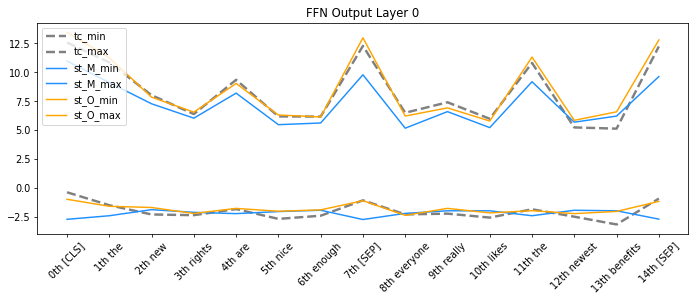

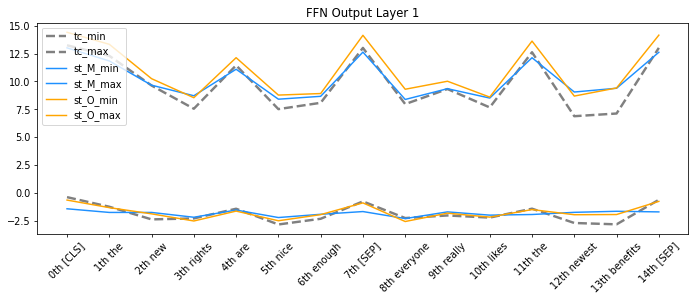

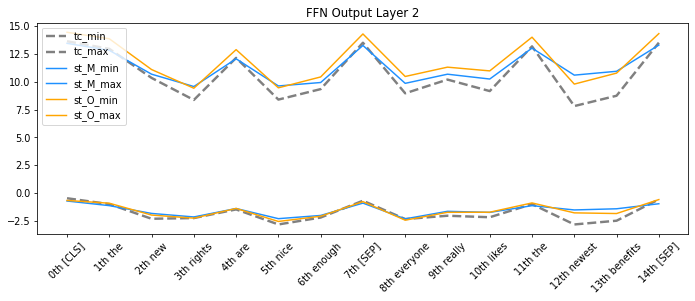

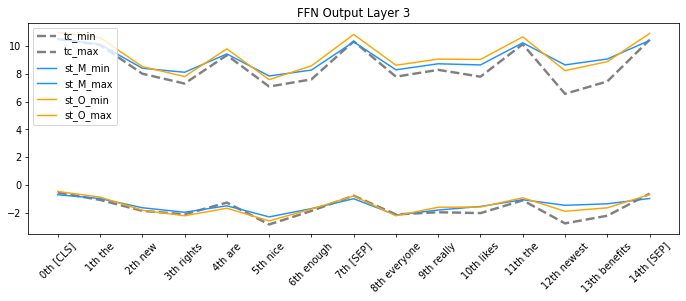

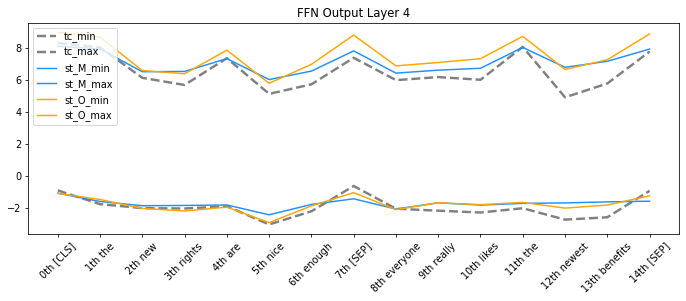

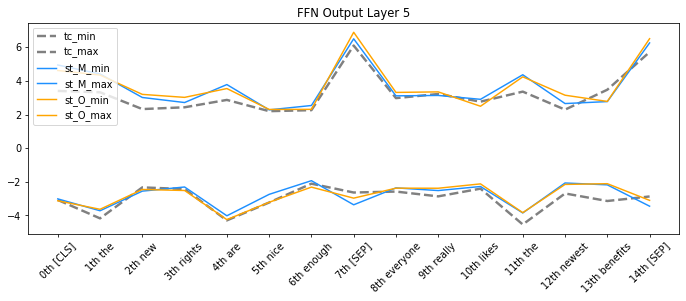

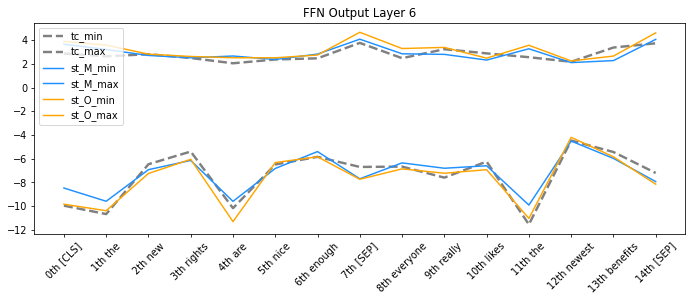

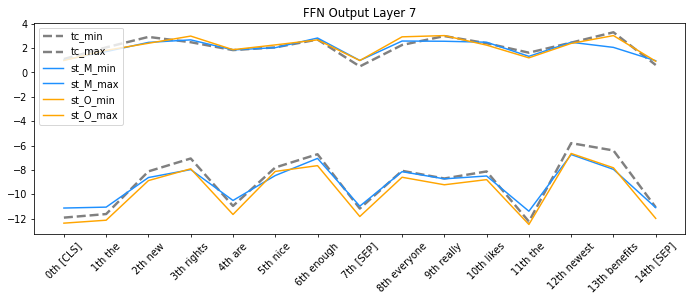

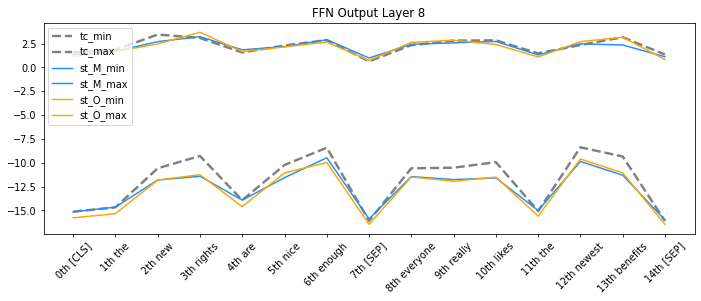

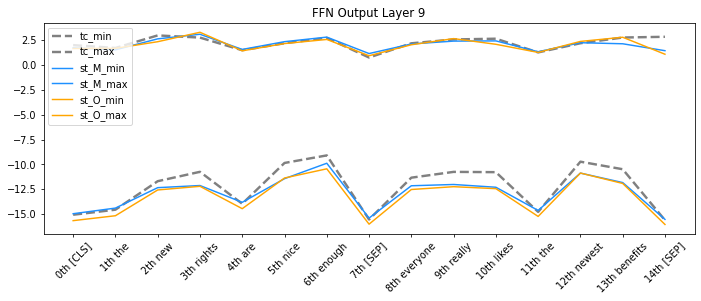

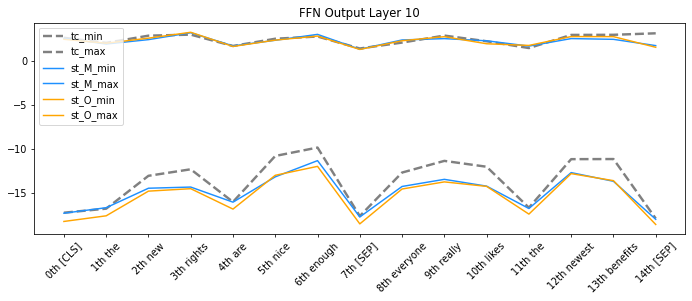

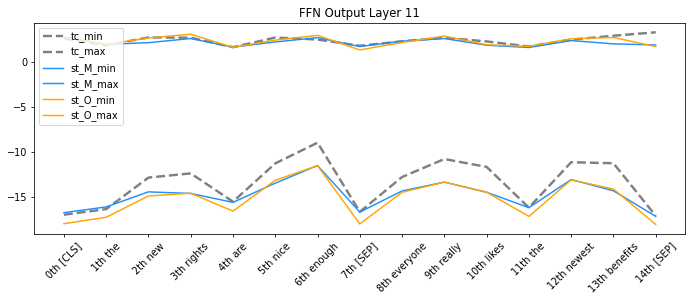

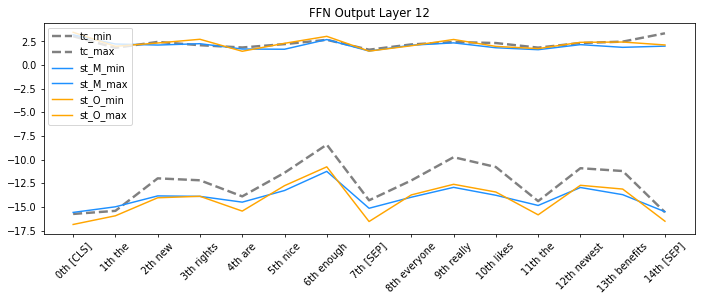

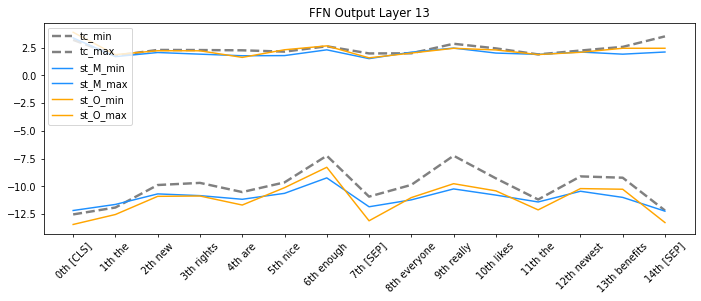

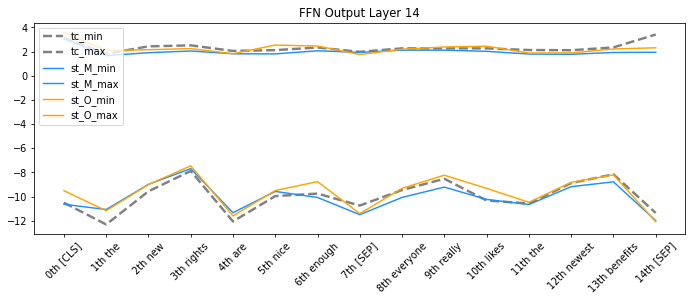

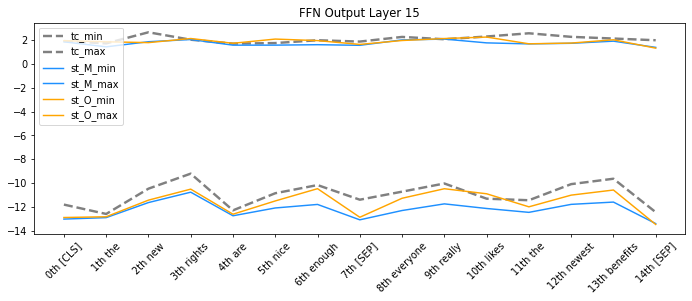

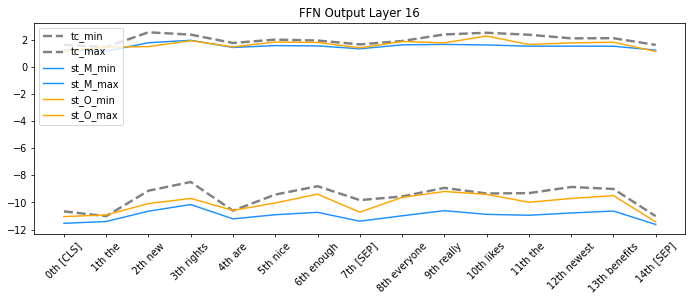

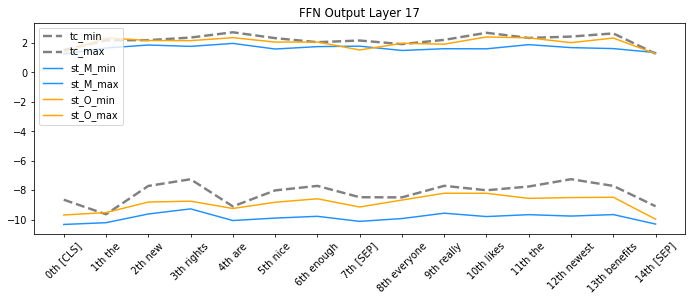

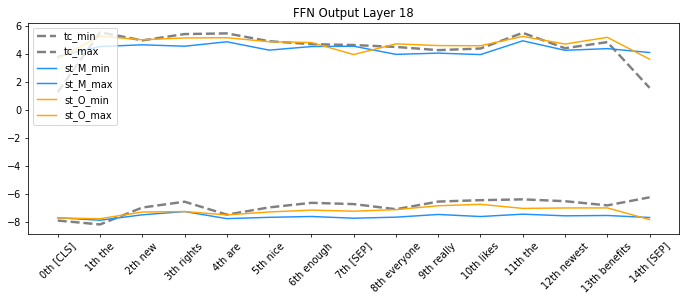

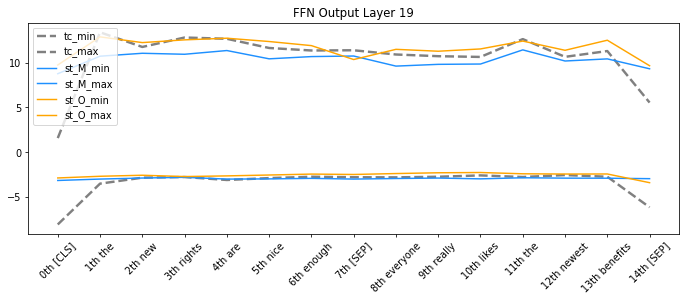

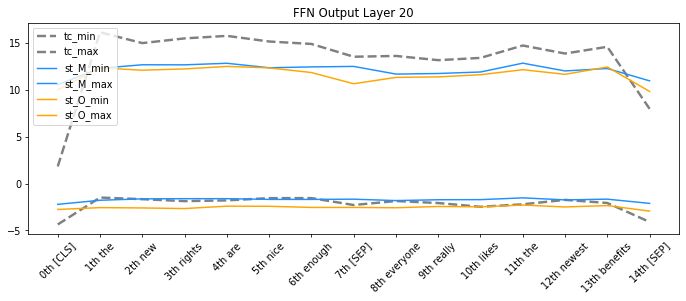

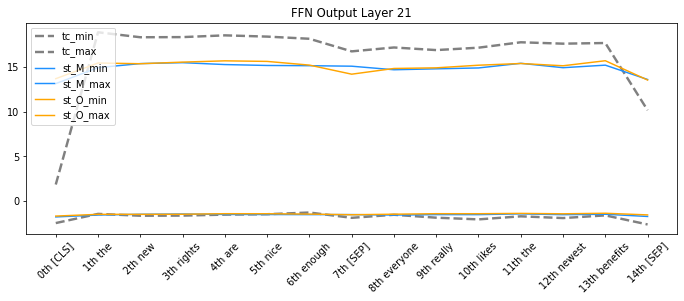

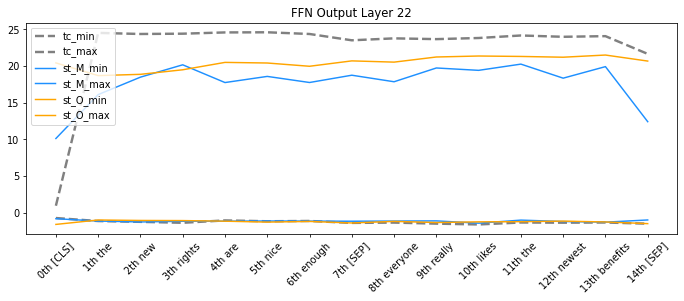

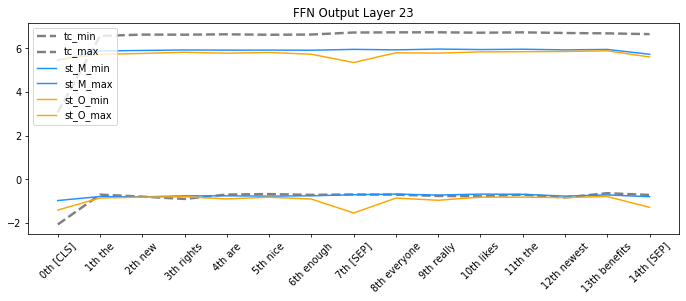

In [250]:
model_num = 0
for l in range(layer_num):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=70)
    ax.plot(tokens, mag_dict[f"tc_min_{l}"], label="tc_min", color="gray", linewidth=2.5, linestyle="--")
    ax.plot(tokens, mag_dict[f"tc_max_{l}"], label="tc_max", color="gray", linewidth=2.5, linestyle="--")
    # ax.plot(tokens, mag_dict[f"tc_mean_{l}"], label="tc_mean", color="r")

    ax.plot(tokens, mag_dict[f"0_min_{l}"], label="st_M_min", color="dodgerblue")
    ax.plot(tokens, mag_dict[f"0_max_{l}"], label="st_M_max", color="dodgerblue")
    
    ax.plot(tokens, mag_dict[f"1_min_{l}"], label="st_O_min", color="orange")
    ax.plot(tokens, mag_dict[f"1_max_{l}"], label="st_O_max", color="orange")
    
    # ax.plot(tokens, mag_dict[f"2_min_{l}"], label="st_I_O_min", color="r", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"2_max_{l}"], label="st_I_O_max", color="r", linestyle="-.")
    # ax.plot(tokens, mag_dict[f"{model_num}_mean_{l}"], label="st_mean", color="dodgerblue")
    ax.set_title(f"FFN Output Layer {l}")
    ax.legend(loc=2)
    plt.xticks(rotation=45)
    plt.show()

## Token Comparison

In [194]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)


# Teacher Model Build
teacher_model_dir = os.path.join(model_dir,task_name)
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()
model = teacher_model
    
ternary_name = "ternary_save"
sarq_name_1 = "1SB_map_M"
sarq_name_2 = "1SB_map_O"
sarq_name_3 = "1SB_I_map_O"

model_list = [ternary_name, sarq_name_1, sarq_name_2, sarq_name_3]
model_list = model_list[1:]

model_num = 0

context_dict = dict()
value_dict = dict()
attn_dict = dict()
sa_dict = dict()
ffn_dict = dict()
prob_dict = dict()
    
for st_model_name in model_list:
    # Student Model Build
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   
    student_config = BertConfig.from_pretrained(student_model_dir)             
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    model = student_model

    # Quantization Option ACT/WEIGHT
    for name, module in student_model.named_modules():
        if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
            module.act_flag = True
            module.weight_flag = True

    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_zip = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)
    
    context_dict[f"{model_num}_sep_1"] = []; context_dict[f"{model_num}_sep_2"] = []; context_dict[f"{model_num}_cls"] = []; context_dict[f"{model_num}_punc_1"] = []; context_dict[f"{model_num}_punc_2"] = []; context_dict[f"{model_num}_other"] = []
    attn_dict[f"{model_num}_sep_1"] = []; attn_dict[f"{model_num}_sep_2"] = []; attn_dict[f"{model_num}_cls"] = []; attn_dict[f"{model_num}_punc_1"] = []; attn_dict[f"{model_num}_punc_2"] = []; attn_dict[f"{model_num}_other"] = []
    value_dict[f"{model_num}_sep_1"] = []; value_dict[f"{model_num}_sep_2"] = []; value_dict[f"{model_num}_cls"] = []; value_dict[f"{model_num}_punc_1"] = []; value_dict[f"{model_num}_punc_2"] = []; value_dict[f"{model_num}_other"] = []
    sa_dict[f"{model_num}_sep_1"] = []; sa_dict[f"{model_num}_sep_2"] = []; sa_dict[f"{model_num}_cls"] = []; sa_dict[f"{model_num}_punc_1"] = []; sa_dict[f"{model_num}_punc_2"] = []; sa_dict[f"{model_num}_other"] = []
    ffn_dict[f"{model_num}_sep_1"] = []; ffn_dict[f"{model_num}_sep_2"] = []; ffn_dict[f"{model_num}_cls"] = []; ffn_dict[f"{model_num}_punc_1"] = []; ffn_dict[f"{model_num}_punc_2"] = []; ffn_dict[f"{model_num}_other"] = []
    prob_dict[f"{model_num}_kl_div"] = []; prob_dict[f"{model_num}_mse"] = []
    
    for l in range(layer_num):
        tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
        st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[l]
        st_ffn_output = student_reps[l]
        tc_ffn_output = teacher_reps[l]
        
        # Attention Output
        diff_sep_1 = mse_func(st_attn_output[0,sep_index[0],:], tc_attn_output[0,sep_index[0],:]) 
        attn_dict[f"{model_num}_sep_1"].append(diff_sep_1.item())
        if len(sep_index) == 2:
            diff_sep_2 = mse_func(st_attn_output[0,sep_index[1],:], tc_attn_output[0,sep_index[1],:]) 
            attn_dict[f"{model_num}_sep_2"].append(diff_sep_2.item())

        diff_cls = mse_func(st_attn_output[0,0,:], tc_attn_output[0,0,:])
        attn_dict[f"{model_num}_cls"].append((diff_cls).item())

        diff_punc_1 = mse_func(st_attn_output[0,sep_index[0]-1,:], tc_attn_output[0,sep_index[0]-1,:])
        attn_dict[f"{model_num}_punc_1"].append(diff_punc_1.item())
        if len(sep_index) == 2:
            diff_punc_2 = mse_func(st_attn_output[0,sep_index[1]-1,:], tc_attn_output[0,sep_index[1]-1,:]) 
            attn_dict[f"{model_num}_punc_2"].append(diff_punc_1.item())

        if len(sep_index) == 2:
            st_attn_output[0,sep_index[0],:] = 0
            tc_attn_output[0,sep_index[0],:] = 0        
            st_attn_output[0,sep_index[1],:] = 0
            tc_attn_output[0,sep_index[1],:] = 0
        else:
            st_attn_output[0,sep_index[0],:] = 0
            tc_attn_output[0,sep_index[0],:] = 0        

        if len(sep_index) == 2:        
            st_attn_output[0,sep_index[0]-1,:] = 0
            tc_attn_output[0,sep_index[0]-1,:] = 0        
            st_attn_output[0,sep_index[1]-1,:] = 0
            tc_attn_output[0,sep_index[1]-1,:] = 0
        else:
            st_attn_output[0,sep_index[0]-1,:] = 0
            tc_attn_output[0,sep_index[0]-1,:] = 0

        st_attn_output[0,0,:] = 0
        tc_attn_output[0,0,:] = 0

        diff_other = mse_func(st_attn_output[0,:,:], tc_attn_output[0,:,:])
        attn_dict[f"{model_num}_other"].append(diff_other.item())

        # SA Output
        diff_sep_1 = mse_func(st_sa_output[0,sep_index[0],:], tc_sa_output[0,sep_index[0],:]) 
        sa_dict[f"{model_num}_sep_1"].append(diff_sep_1.item())
        if len(sep_index) == 2:
            diff_sep_2 = mse_func(st_sa_output[0,sep_index[1],:], tc_sa_output[0,sep_index[1],:]) 
            sa_dict[f"{model_num}_sep_2"].append(diff_sep_2.item())

        diff_cls = mse_func(st_sa_output[0,0,:], tc_sa_output[0,0,:])
        sa_dict[f"{model_num}_cls"].append((diff_cls).item())

        diff_punc_1 = mse_func(st_sa_output[0,sep_index[0]-1,:], tc_sa_output[0,sep_index[0]-1,:])
        sa_dict[f"{model_num}_punc_1"].append(diff_punc_1.item())
        if len(sep_index) == 2:
            diff_punc_2 = mse_func(st_sa_output[0,sep_index[1]-1,:], tc_sa_output[0,sep_index[1]-1,:]) 
            sa_dict[f"{model_num}_punc_2"].append(diff_punc_1.item())

        if len(sep_index) == 2:
            st_sa_output[0,sep_index[0],:] = 0
            tc_sa_output[0,sep_index[0],:] = 0        
            st_sa_output[0,sep_index[1],:] = 0
            tc_sa_output[0,sep_index[1],:] = 0
        else:
            st_sa_output[0,sep_index[0],:] = 0
            tc_sa_output[0,sep_index[0],:] = 0        

        if len(sep_index) == 2:        
            st_sa_output[0,sep_index[0]-1,:] = 0
            tc_sa_output[0,sep_index[0]-1,:] = 0        
            st_sa_output[0,sep_index[1]-1,:] = 0
            tc_sa_output[0,sep_index[1]-1,:] = 0
        else:
            st_sa_output[0,sep_index[0]-1,:] = 0
            tc_sa_output[0,sep_index[0]-1,:] = 0

        st_sa_output[0,0,:] = 0
        tc_sa_output[0,0,:] = 0

        diff_other = mse_func(st_sa_output[0,:,:], tc_sa_output[0,:,:])
        sa_dict[f"{model_num}_other"].append(diff_other.item())
        
        # FFN Output
        diff_sep_1 = mse_func(st_ffn_output[0,sep_index[0],:], tc_ffn_output[0,sep_index[0],:]) 
        ffn_dict[f"{model_num}_sep_1"].append(diff_sep_1.item())
        if len(sep_index) == 2:
            diff_sep_2 = mse_func(st_ffn_output[0,sep_index[1],:], tc_ffn_output[0,sep_index[1],:]) 
            ffn_dict[f"{model_num}_sep_2"].append(diff_sep_2.item())

        diff_cls = mse_func(st_ffn_output[0,0,:], tc_ffn_output[0,0,:])
        ffn_dict[f"{model_num}_cls"].append((diff_cls).item())

        diff_punc_1 = mse_func(st_ffn_output[0,sep_index[0]-1,:], tc_ffn_output[0,sep_index[0]-1,:])
        ffn_dict[f"{model_num}_punc_1"].append(diff_punc_1.item())
        if len(sep_index) == 2:
            diff_punc_2 = mse_func(st_ffn_output[0,sep_index[1]-1,:], tc_ffn_output[0,sep_index[1]-1,:]) 
            ffn_dict[f"{model_num}_punc_2"].append(diff_punc_1.item())

        if len(sep_index) == 2:
            st_ffn_output[0,sep_index[0],:] = 0
            tc_ffn_output[0,sep_index[0],:] = 0        
            st_ffn_output[0,sep_index[1],:] = 0
            tc_ffn_output[0,sep_index[1],:] = 0
        else:
            st_ffn_output[0,sep_index[0],:] = 0
            tc_ffn_output[0,sep_index[0],:] = 0        

        if len(sep_index) == 2:        
            st_ffn_output[0,sep_index[0]-1,:] = 0
            tc_ffn_output[0,sep_index[0]-1,:] = 0        
            st_ffn_output[0,sep_index[1]-1,:] = 0
            tc_ffn_output[0,sep_index[1]-1,:] = 0
        else:
            st_ffn_output[0,sep_index[0]-1,:] = 0
            tc_ffn_output[0,sep_index[0]-1,:] = 0

        st_ffn_output[0,0,:] = 0
        tc_ffn_output[0,0,:] = 0

        diff_other = mse_func(st_ffn_output[0,:,:], tc_ffn_output[0,:,:])
        ffn_dict[f"{model_num}_other"].append(diff_other.item())

        
        for h in range(head_num):            
            # Context
            diff_sep_1 = mse_func(st_attn_context[0,h,sep_index[0],:], tc_attn_context[0,h,sep_index[0],:]) 
            context_dict[f"{model_num}_sep_1"].append(diff_sep_1.item())
            if len(sep_index) == 2:
                diff_sep_2 = mse_func(st_attn_context[0,h,sep_index[1],:], tc_attn_context[0,h,sep_index[1],:]) 
                context_dict[f"{model_num}_sep_2"].append(diff_sep_2.item())
                
            diff_cls = mse_func(st_attn_context[0,h,0,:], tc_attn_context[0,h,0,:])
            context_dict[f"{model_num}_cls"].append((diff_cls).item())

            diff_punc_1 = mse_func(st_attn_context[0,h,sep_index[0]-1,:], tc_attn_context[0,h,sep_index[0]-1,:])
            context_dict[f"{model_num}_punc_1"].append(diff_punc_1.item())
            if len(sep_index) == 2:
                diff_punc_2 = mse_func(st_attn_context[0,h,sep_index[1]-1,:], tc_attn_context[0,h,sep_index[1]-1,:]) 
                context_dict[f"{model_num}_punc_2"].append(diff_punc_1.item())

            if len(sep_index) == 2:
                st_attn_context[0,h,sep_index[0],:] = 0
                tc_attn_context[0,h,sep_index[0],:] = 0        
                st_attn_context[0,h,sep_index[1],:] = 0
                tc_attn_context[0,h,sep_index[1],:] = 0
            else:
                st_attn_context[0,h,sep_index[0],:] = 0
                tc_attn_context[0,h,sep_index[0],:] = 0        

            if len(sep_index) == 2:        
                st_attn_context[0,h,sep_index[0]-1,:] = 0
                tc_attn_context[0,h,sep_index[0]-1,:] = 0        
                st_attn_context[0,h,sep_index[1]-1,:] = 0
                tc_attn_context[0,h,sep_index[1]-1,:] = 0
            else:
                st_attn_context[0,h,sep_index[0]-1,:] = 0
                tc_attn_context[0,h,sep_index[0]-1,:] = 0

            st_attn_context[0,h,0,:] = 0
            tc_attn_context[0,h,0,:] = 0

            diff_other = mse_func(st_attn_context[0,h,:,:], tc_attn_context[0,h,:,:])
            context_dict[f"{model_num}_other"].append(diff_other.item())
            
            # Value
            diff_sep_1 = mse_func(st_value_vector[0,h,sep_index[0],:], tc_value_vector[0,h,sep_index[0],:]) 
            value_dict[f"{model_num}_sep_1"].append(diff_sep_1.item())
            if len(sep_index) == 2:
                diff_sep_2 = mse_func(st_value_vector[0,h,sep_index[1],:], tc_value_vector[0,h,sep_index[1],:]) 
                value_dict[f"{model_num}_sep_2"].append(diff_sep_2.item())

            diff_cls = mse_func(st_value_vector[0,h,0,:], tc_value_vector[0,h,0,:])
            value_dict[f"{model_num}_cls"].append((diff_cls).item())

            diff_punc_1 = mse_func(st_value_vector[0,h,sep_index[0]-1,:], tc_value_vector[0,h,sep_index[0]-1,:])
            value_dict[f"{model_num}_punc_1"].append(diff_punc_1.item())
            if len(sep_index) == 2:
                diff_punc_2 = mse_func(st_value_vector[0,h,sep_index[1]-1,:], tc_value_vector[0,h,sep_index[1]-1,:]) 
                value_dict[f"{model_num}_punc_2"].append(diff_punc_1.item())

            if len(sep_index) == 2:
                st_value_vector[0,h,sep_index[0],:] = 0
                tc_value_vector[0,h,sep_index[0],:] = 0        
                st_value_vector[0,h,sep_index[1],:] = 0
                tc_value_vector[0,h,sep_index[1],:] = 0
            else:
                st_value_vector[0,h,sep_index[0],:] = 0
                tc_value_vector[0,h,sep_index[0],:] = 0        

            if len(sep_index) == 2:        
                st_value_vector[0,h,sep_index[0]-1,:] = 0
                tc_value_vector[0,h,sep_index[0]-1,:] = 0        
                st_value_vector[0,h,sep_index[1]-1,:] = 0
                tc_value_vector[0,h,sep_index[1]-1,:] = 0
            else:
                st_value_vector[0,h,sep_index[0]-1,:] = 0
                tc_value_vector[0,h,sep_index[0]-1,:] = 0

            st_value_vector[0,h,0,:] = 0
            tc_value_vector[0,h,0,:] = 0

            diff_other = mse_func(st_value_vector[0,h,:,:], tc_value_vector[0,h,:,:])
            value_dict[f"{model_num}_other"].append(diff_other.item())
    # Attention Prob KL Div
    for l in range(layer_num):
        for h in range(head_num): 
            student = student_probs[l][0,h,:,:]
            teacher = teacher_probs[l][0,h,:,:]
            neg_cross_entropy = teacher * torch.log(student) 
            neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)


            # p(t) log p(t) = negative entropy
            neg_entropy = teacher * torch.log(teacher) 
            neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)

            kl_div = neg_entropy - neg_cross_entropy
            
            prob_dict[f"{model_num}_kl_div"].append(kl_div.mean().item())
            mse_diff = mse_func(teacher, student)
            prob_dict[f"{model_num}_mse"].append(mse_diff.item())
            
    model_num += 1
    print(f"{st_model_name} DONE")



05/09 10:48:00 PM Loading model models/BERT_large/rte/pytorch_model.bin
05/09 10:48:01 PM loading model...
05/09 10:48:01 PM done!
05/09 10:48:01 PM Weights from pretrained model not used in BertForSequenceClassification: ['bert.embeddings.position_ids']
05/09 10:48:01 PM loading configuration file output/BERT_large/rte/exploration/1SB_map_M/config.json
05/09 10:48:07 PM Loading model output/BERT_large/rte/exploration/1SB_map_M/pytorch_model.bin
05/09 10:48:07 PM loading model...
05/09 10:48:08 PM done!
1SB_map_M DONE
05/09 10:48:09 PM loading configuration file output/BERT_large/rte/exploration/1SB_map_O/config.json
05/09 10:48:14 PM Loading model output/BERT_large/rte/exploration/1SB_map_O/pytorch_model.bin
05/09 10:48:15 PM loading model...
05/09 10:48:15 PM done!
1SB_map_O DONE
05/09 10:48:17 PM loading configuration file output/BERT_large/rte/exploration/1SB_I_map_O/config.json
05/09 10:48:22 PM Loading model output/BERT_large/rte/exploration/1SB_I_map_O/pytorch_model.bin
05/09 10

In [195]:
def plot_token_rep(dict, layer_num, haed_num, two_sent, name=None, multi_head=True):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 15), dpi=70)
    font_size = 15
    line_w = 1
    
    if multi_head:
        x_axis_num = layer_num * head_num
    else:
        x_axis_num = layer_num
    
    ax1_color = 'dodgerblue'#"tab:orange"
    sarq_color = 'orange'# "tab:blue"
    sarq_output_color_1 = "r"# "tab:gray"
    sarq_output_color_2 = "tab:pink"

    ax1.plot(list(range(x_axis_num)),dict["0_sep_1"], label=model_list[0], color=ax1_color, linewidth=line_w)
    ax1.plot(list(range(x_axis_num)),dict["1_sep_1"], label=model_list[1], color=sarq_color, linewidth=line_w)
    ax1.plot(list(range(x_axis_num)),dict["2_sep_1"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
    
    ax1.set_title(f"{name} [SEP]-1", fontsize=font_size)
    ax1.legend(fontsize=font_size, loc=2)

    if two_sent:
        ax2.plot(list(range(x_axis_num)),dict["0_sep_2"], label=model_list[0], color=ax1_color, linewidth=line_w)
        ax2.plot(list(range(x_axis_num)),dict["1_sep_2"], label=model_list[1], color=sarq_color, linewidth=line_w)
        ax2.plot(list(range(x_axis_num)),dict["2_sep_2"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
        ax2.set_title(f"{name} [SEP]-2", fontsize=font_size)
        ax2.legend(fontsize=font_size, loc=2)

    ax3.plot(list(range(x_axis_num)),dict["0_punc_1"], label=model_list[0], color=ax1_color, linewidth=line_w)
    ax3.plot(list(range(x_axis_num)),dict["1_punc_1"], label=model_list[1], color=sarq_color, linewidth=line_w)
    ax3.plot(list(range(x_axis_num)),dict["2_punc_1"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
    ax3.set_title(f"{name} [PUNC]-1", fontsize=font_size)
    ax3.legend(fontsize=font_size, loc=2)

    if two_sent:
        ax4.plot(list(range(x_axis_num)),dict["0_punc_2"], label=model_list[0], color=ax1_color, linewidth=line_w)
        ax4.plot(list(range(x_axis_num)),dict["1_punc_2"], label=model_list[1], color=sarq_color, linewidth=line_w)
        ax4.plot(list(range(x_axis_num)),dict["2_punc_2"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
        ax4.set_title(f"{name} [PUNC]-2", fontsize=font_size)
        ax4.legend(fontsize=font_size, loc=2)

    ax5.plot(list(range(x_axis_num)),dict["0_cls"], label=model_list[0], color=ax1_color, linewidth=line_w)
    ax5.plot(list(range(x_axis_num)),dict["1_cls"], label=model_list[1], color=sarq_color, linewidth=line_w)
    ax5.plot(list(range(x_axis_num)),dict["2_cls"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
    ax5.set_title(f"{name} [CLS]", fontsize=font_size)
    ax5.legend(fontsize=font_size, loc=2)

    ax6.plot(list(range(x_axis_num)),dict["0_other"], label=model_list[0], color=ax1_color, linewidth=line_w)
    ax6.plot(list(range(x_axis_num)),dict["1_other"], label=model_list[1], color=sarq_color, linewidth=line_w)
    ax6.plot(list(range(x_axis_num)),dict["2_other"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
    ax6.set_title(f"{name} [Other]", fontsize=font_size)
    ax6.legend(fontsize=font_size, loc=2)



=> Attention Map KL Distance


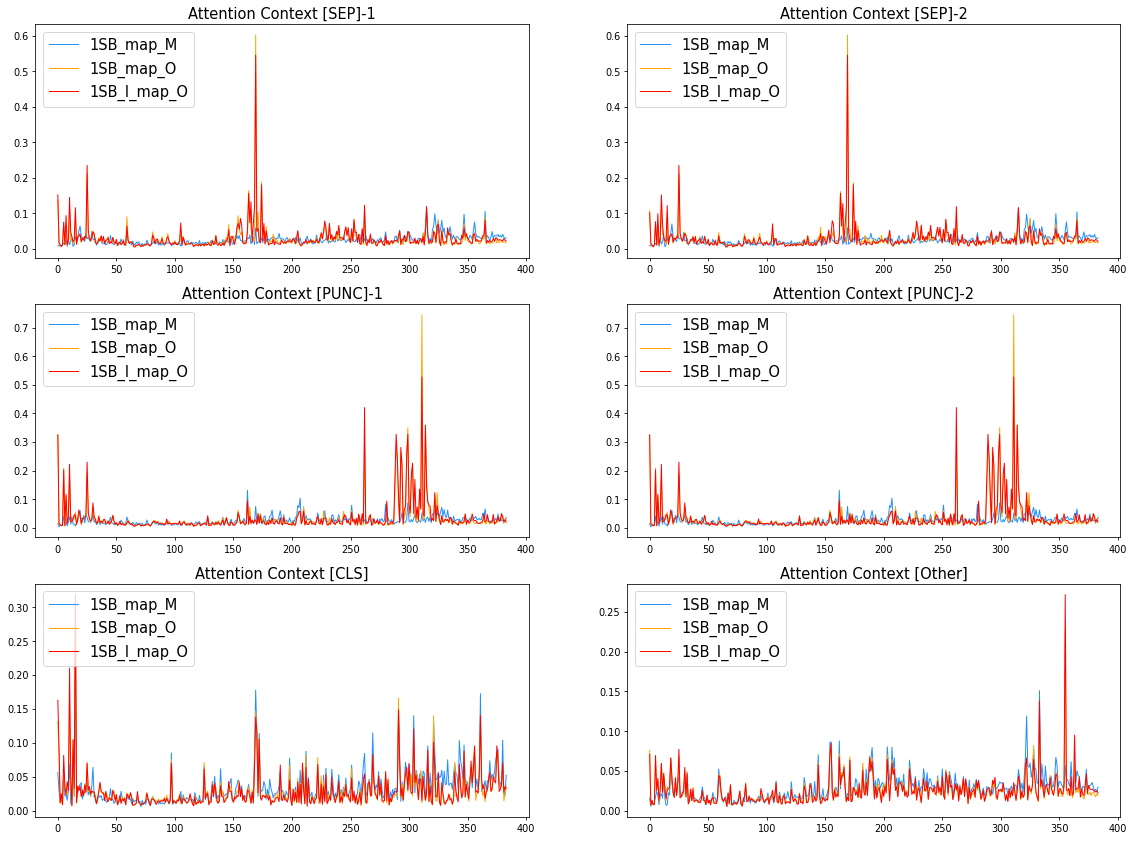

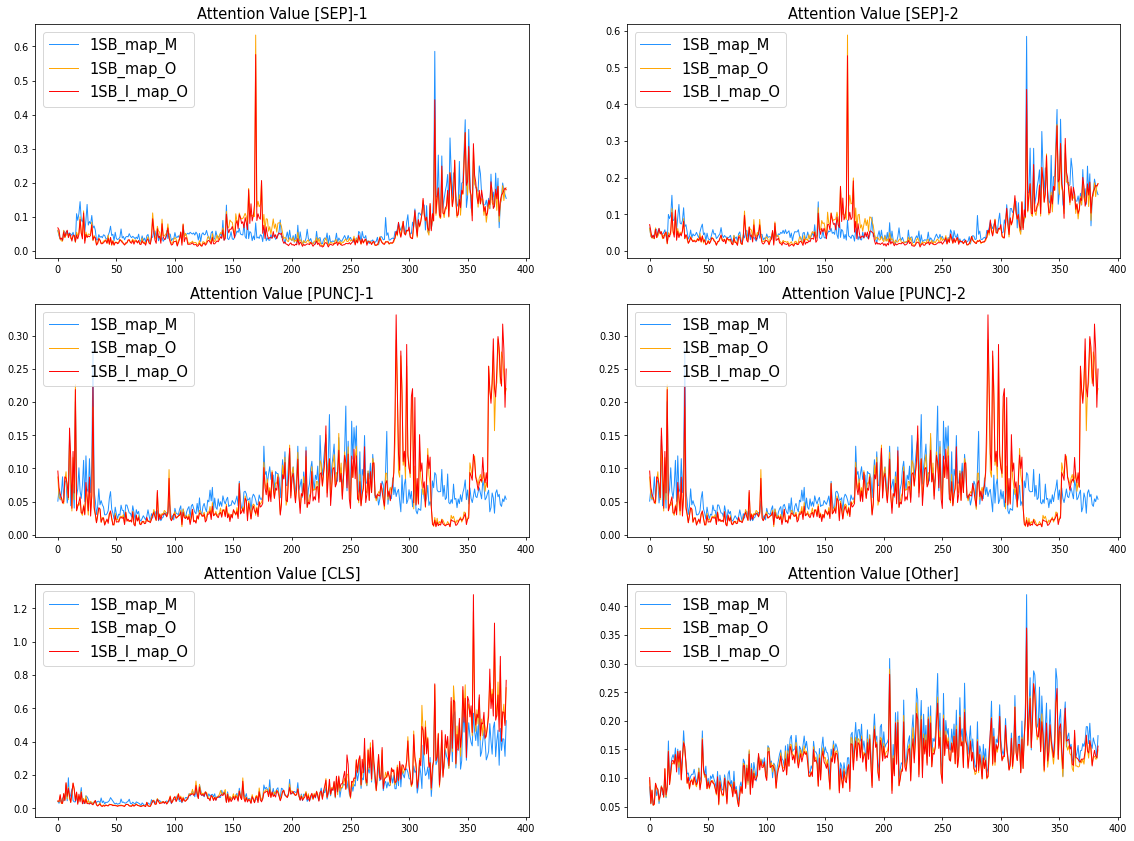

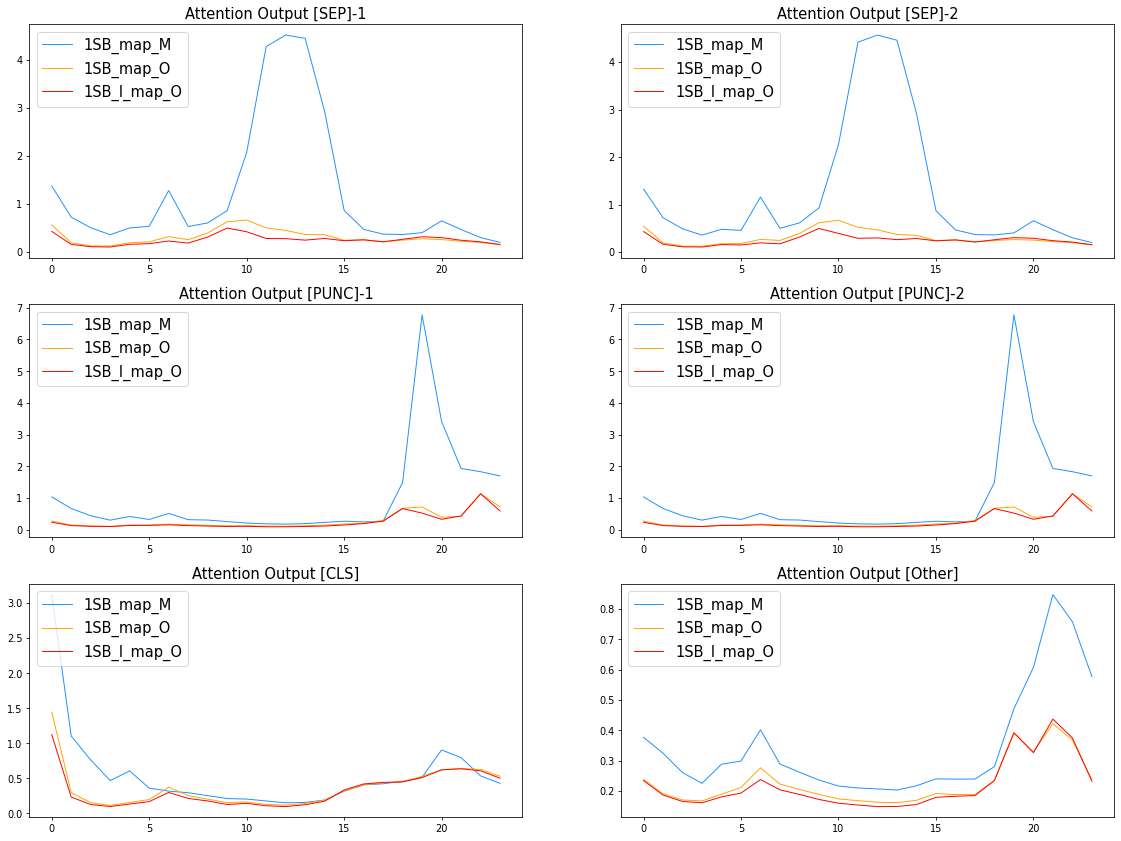

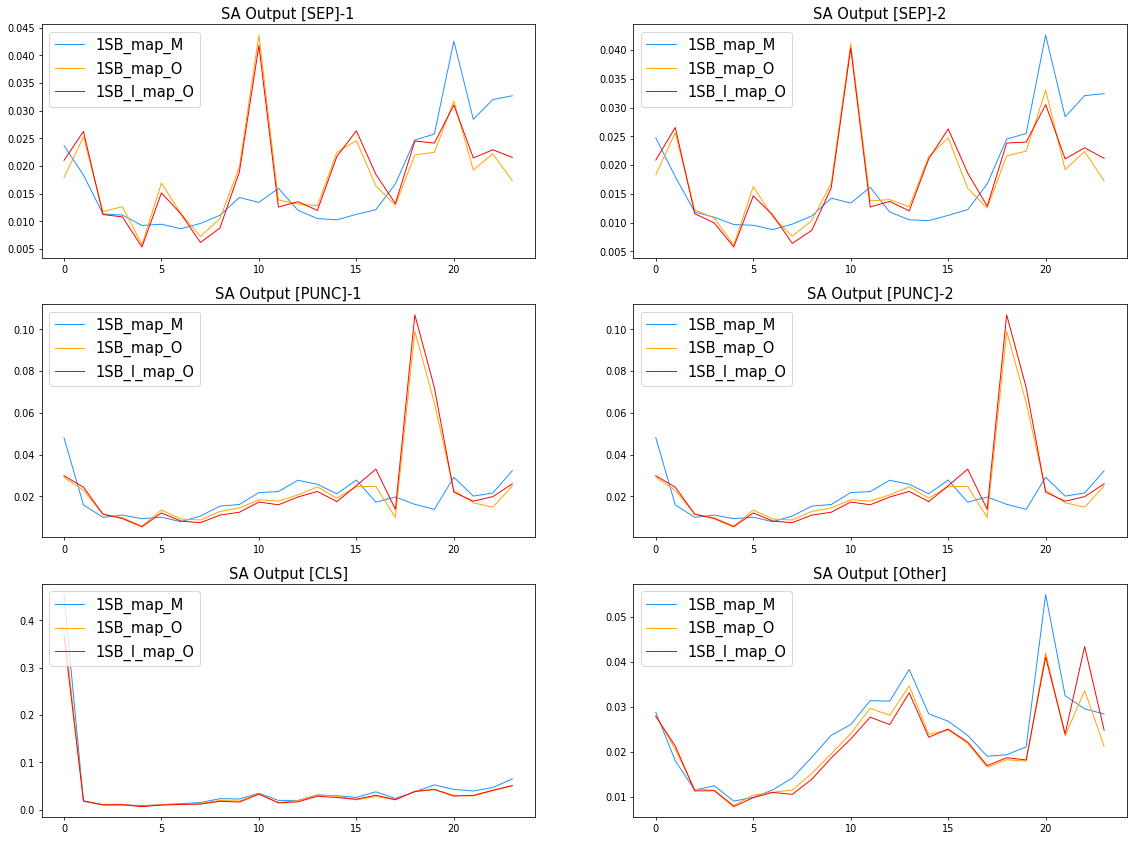

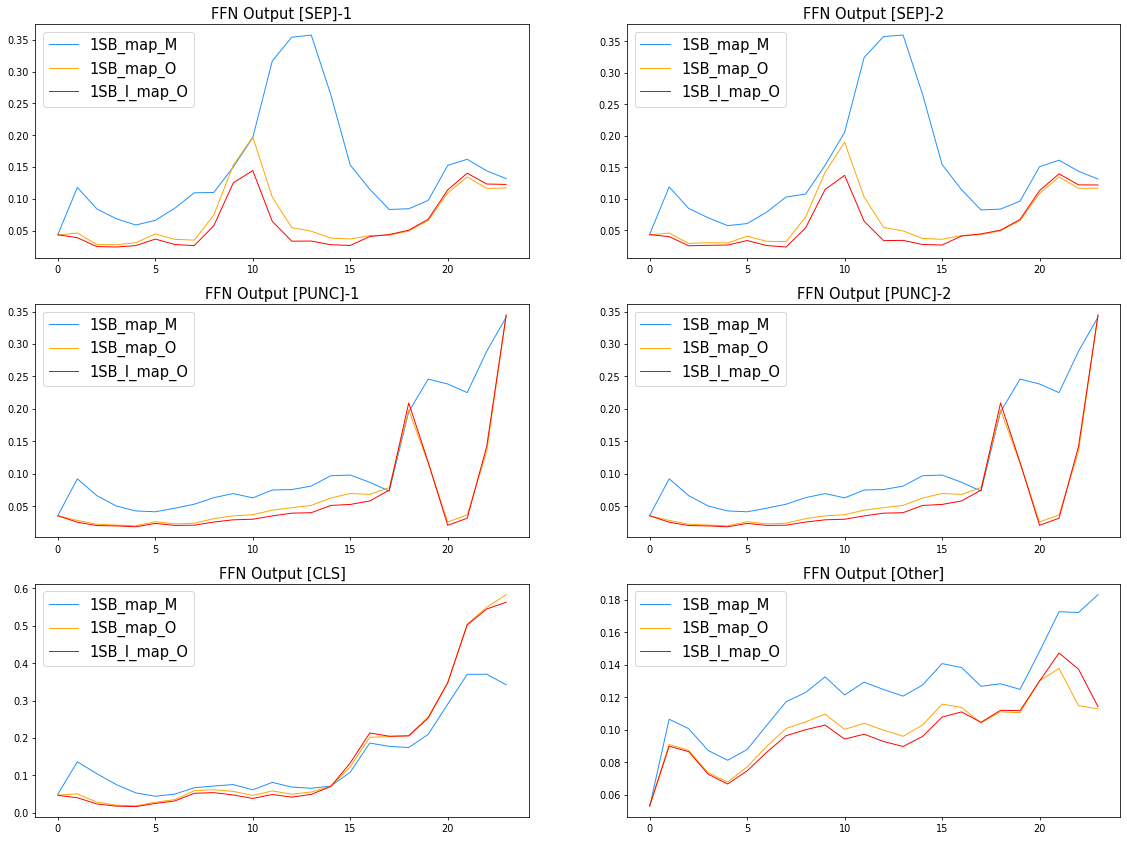

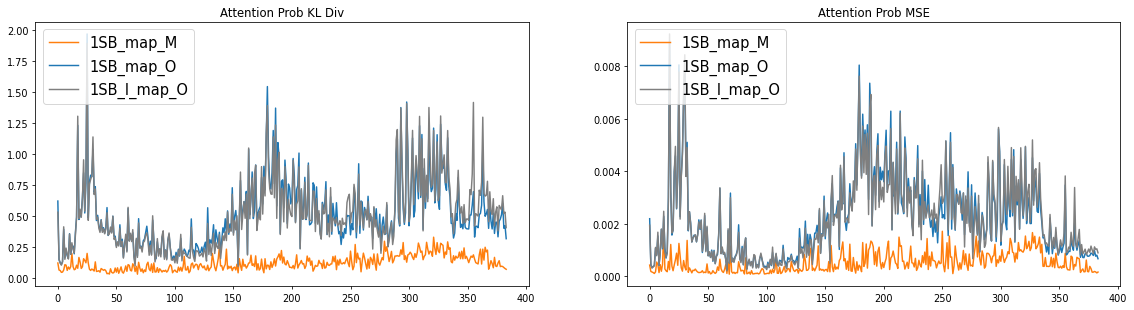

In [197]:
if len(sep_index) == 2:
    two_sent = True
else:
    two_sent = False

plot_token_rep(context_dict, layer_num, head_num, two_sent, name="Attention Context")
plot_token_rep(value_dict, layer_num, head_num, two_sent, name="Attention Value")
plot_token_rep(attn_dict, layer_num, head_num, two_sent, name="Attention Output",multi_head=False)
plot_token_rep(sa_dict, layer_num, head_num, two_sent, name="SA Output", multi_head=False)
plot_token_rep(ffn_dict, layer_num, head_num, two_sent, name="FFN Output", multi_head=False)

print("=====================================================================================================================")
print("=> Attention Map KL Distance")
print("=====================================================================================================================")
# prob_dict[f"{model_num}_kl_div"] = []; prob_dict[f"{model_num}_mse"] = []
x_axis_num = layer_num * head_num
ax1_color = "tab:orange"
sarq_color = "tab:blue"
sarq_output_color_1 = "tab:gray"
font_size = 15
line_w = 1.5
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5), dpi=70)
ax1.plot(list(range(x_axis_num)),prob_dict["0_kl_div"], label=model_list[0], color=ax1_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),prob_dict["1_kl_div"], label=model_list[1], color=sarq_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),prob_dict["2_kl_div"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
ax1.set_title("Attention Prob KL Div")
ax1.legend(fontsize=font_size, loc=2)

ax2.plot(list(range(x_axis_num)),prob_dict["0_mse"], label=model_list[0], color=ax1_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),prob_dict["1_mse"], label=model_list[1], color=sarq_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),prob_dict["2_mse"], label=model_list[2], color=sarq_output_color_1, linewidth=line_w)
ax2.set_title("Attention Prob MSE")
ax2.legend(fontsize=font_size, loc=2)


In [16]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)

# st_model_name = "ternary_save"
# st_model_name = "step_2_context"
# st_model_name = "step_2_output"
# st_model_name = "step_2"
# st_model_name = "sarq_step1"



build_tc = 1
build_st = 1

if build_tc:
    # Teacher Model Build
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()
    model = teacher_model

    
ternary_name = "ternary_save"
sarq_name_1 = "step_2"
sarq_name_2 = "1SB_map_M"
sarq_name_3 = "1SB_map_O"

# for st_model_name in [ternary_name, sarq_name_1, sarq_name_2, sarq_name_3]:
for st_model_name in [sarq_name_2, sarq_name_3]:
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   

    if build_st:
        # Student Model Build
        student_config = BertConfig.from_pretrained(student_model_dir)
#                                                         quantize_act=True,
#                                                         quantize_weight=True,
#                                                         weight_bits = 2, # Always Ternary when "quantize_weight = True"
#                                                         input_bits = 8,
#                                                         clip_val = 2.5,
#                                                         quantize = True,
#                                                         ffn_q_1 = True,
#                                                         ffn_q_2 = True,
#                                                         qkv_q = True,
#                                                         emb_q = True,
#                                                         cls_q = True,
#                                                         clipping = False,
#                                                         layer_num = -1,
#                                                         mean_scale = 0.7,
#                                                         quantizer = "ternary",
#                                                         act_quantizer = "ternary",
#                                                         init_scaling = 1,
#                                                         clip_ratio = 1,
#                                                         gradient_scaling = False,
#                                                         clip_method = "minmax",
#                                                         teacher_attnmap = False,
#                                                         parks = False,
#                                                         stop_grad = False,
#                                                         qk_FP = False,
#                                                         map=False,
#                                                         act_method = "clipping"
#                                                         )

        student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
        student_model.to(device)
        model = student_model
        print()

        # Quantization Option ACT/WEIGHT
        for name, module in student_model.named_modules():
            if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
                module.act_flag = True
                module.weight_flag = True

    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)

    st_values = student_values
    tc_values = teacher_values

    norm_type = 3 # 1 : Attention Output 0 : Layer Context

    h_num = 1
    sep_list = []
    cls_list = []
    punc_list = []
    other_list = []
    for l in range(layer_num):
        if len(sep_index) == 2:
            diff_sep_1 = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
            diff_sep_2 = mse_func(st_values[l][norm_type][0,sep_index[1],:], tc_values[l][norm_type][0,sep_index[1],:]) 
            sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
        else:
            diff_sep = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
            sep_list.append(diff_sep.item())

        diff_cls = mse_func(st_values[l][norm_type][0,0,:], tc_values[l][norm_type][0,0,:])
        cls_list.append((diff_cls).item())

        if len(sep_index) == 2:
            diff_punc_1 = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
            diff_punc_2 = mse_func(st_values[l][norm_type][0,sep_index[1]-1,:], tc_values[l][norm_type][0,sep_index[1]-1,:]) 
            punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
        else:
            diff_punc = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
            punc_list.append((diff_punc).item())

        if len(sep_index) == 2:
            st_values[l][norm_type][0,sep_index[0],:] = 0
            tc_values[l][norm_type][0,sep_index[0],:] = 0        
            st_values[l][norm_type][0,sep_index[1],:] = 0
            tc_values[l][norm_type][0,sep_index[1],:] = 0
        else:
            st_values[l][norm_type][0,sep_index[0],:] = 0
            tc_values[l][norm_type][0,sep_index[0],:] = 0        

        if len(sep_index) == 2:        
            st_values[l][norm_type][0,sep_index[0]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[0]-1,:] = 0        
            st_values[l][norm_type][0,sep_index[1]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[1]-1,:] = 0
        else:
            st_values[l][norm_type][0,sep_index[0]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[0]-1,:] = 0

        st_values[l][norm_type][0,0,:] = 0
        tc_values[l][norm_type][0,0,:] = 0

        diff_other = mse_func(st_values[l][norm_type][0,:,:], tc_values[l][norm_type][0,:,:])
        other_list.append(diff_other.item())

#     for l in range(layer_num):
#         for h in range(head_num): 

#             if len(sep_index) == 2:
#                 diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#                 diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
#                 sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
#             else:
#                 diff_sep = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#                 sep_list.append(diff_sep.item())

#             diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
#             cls_list.append((diff_cls).item())

#             if len(sep_index) == 2:
#                 diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#                 diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
#                 punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
#             else:
#                 diff_punc = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#                 punc_list.append((diff_punc).item())

#             if len(sep_index) == 2:
#                 st_values[l][norm_type][0,h,sep_index[0],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
#                 st_values[l][norm_type][0,h,sep_index[1],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[1],:] = 0
#             else:
#                 st_values[l][norm_type][0,h,sep_index[0],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0],:] = 0        

#             if len(sep_index) == 2:        
#                 st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
#                 st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#             else:
#                 st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0

#             st_values[l][norm_type][0,h,0,:] = 0
#             tc_values[l][norm_type][0,h,0,:] = 0

#             diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
#             other_list.append(diff_other.item())


    if st_model_name == ternary_name:
        print(st_model_name)
        v_t_sep = sep_list 
        v_t_cls = cls_list 
        v_t_punc = punc_list 
        v_t_other = other_list 
    elif st_model_name == sarq_name_1:
        print(st_model_name)    
        v_s_sep = sep_list 
        v_s_cls = cls_list 
        v_s_punc = punc_list 
        v_s_other = other_list 
    elif st_model_name == sarq_name_2:
        print(st_model_name)
        v_sc_sep = sep_list 
        v_sc_cls = cls_list 
        v_sc_punc = punc_list 
        v_sc_other = other_list         
    elif st_model_name == sarq_name_3: 
        print(st_model_name)
        v_so_sep = sep_list 
        v_so_cls = cls_list 
        v_so_punc = punc_list 
        v_so_other = other_list   

    norm_type = 1 # 1 : Attention Output 0 : Layer Context
#    norm_type = 1 # 0 : Context 1 : Value

    h_num = 1
    sep_list = []
    cls_list = []
    punc_list = []
    other_list = []

    tokens
    for l in range(layer_num):
        if len(sep_index) == 2:
            diff_sep_1 = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
            diff_sep_2 = mse_func(st_values[l][norm_type][0,sep_index[1],:], tc_values[l][norm_type][0,sep_index[1],:]) 
            sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
        else:
            diff_sep = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
            sep_list.append(diff_sep.item())

        diff_cls = mse_func(st_values[l][norm_type][0,0,:], tc_values[l][norm_type][0,0,:])
        cls_list.append((diff_cls).item())

        if len(sep_index) == 2:
            diff_punc_1 = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
            diff_punc_2 = mse_func(st_values[l][norm_type][0,sep_index[1]-1,:], tc_values[l][norm_type][0,sep_index[1]-1,:]) 
            punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
        else:
            diff_punc = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
            punc_list.append((diff_punc).item())

        if len(sep_index) == 2:
            st_values[l][norm_type][0,sep_index[0],:] = 0
            tc_values[l][norm_type][0,sep_index[0],:] = 0        
            st_values[l][norm_type][0,sep_index[1],:] = 0
            tc_values[l][norm_type][0,sep_index[1],:] = 0
        else:
            st_values[l][norm_type][0,sep_index[0],:] = 0
            tc_values[l][norm_type][0,sep_index[0],:] = 0        

        if len(sep_index) == 2:        
            st_values[l][norm_type][0,sep_index[0]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[0]-1,:] = 0        
            st_values[l][norm_type][0,sep_index[1]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[1]-1,:] = 0
        else:
            st_values[l][norm_type][0,sep_index[0]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[0]-1,:] = 0

        st_values[l][norm_type][0,0,:] = 0
        tc_values[l][norm_type][0,0,:] = 0

        diff_other = mse_func(st_values[l][norm_type][0,:,:], tc_values[l][norm_type][0,:,:])
        other_list.append(diff_other.item())

#     for l in range(layer_num):
#         for h in range(head_num): 

#             if len(sep_index) == 2:
#                 diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#                 diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
#                 sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
#             else:
#                 diff_sep = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#                 sep_list.append(diff_sep.item())

#             diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
#             cls_list.append((diff_cls).item())

#             if len(sep_index) == 2:
#                 diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#                 diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
#                 punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
#             else:
#                 diff_punc = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#                 punc_list.append((diff_punc).item())

#             if len(sep_index) == 2:
#                 st_values[l][norm_type][0,h,sep_index[0],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
#                 st_values[l][norm_type][0,h,sep_index[1],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[1],:] = 0
#             else:
#                 st_values[l][norm_type][0,h,sep_index[0],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0],:] = 0        

#             if len(sep_index) == 2:        
#                 st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
#                 st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#             else:
#                 st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0

#             st_values[l][norm_type][0,h,0,:] = 0
#             tc_values[l][norm_type][0,h,0,:] = 0

#             diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
#             other_list.append(diff_other.item())

    if st_model_name == ternary_name:
        print(st_model_name)
        vw_t_sep = sep_list 
        vw_t_cls = cls_list 
        vw_t_punc = punc_list 
        vw_t_other = other_list 
    elif st_model_name == sarq_name_1:
        print(st_model_name)
        vw_s_sep = sep_list 
        vw_s_cls = cls_list 
        vw_s_punc = punc_list 
        vw_s_other = other_list 
    elif st_model_name == sarq_name_2:
        print(st_model_name)
        vw_sc_sep = sep_list 
        vw_sc_cls = cls_list 
        vw_sc_punc = punc_list 
        vw_sc_other = other_list   
    elif st_model_name == sarq_name_3: 
        print(st_model_name)
        vw_so_sep = sep_list 
        vw_so_cls = cls_list 
        vw_so_punc = punc_list 
        vw_so_other = other_list   
    
    kld_list = []
    
    for l in range(layer_num):
        for h in range(head_num): 
            student = student_probs[l][0,h,:,:]
            teacher = teacher_probs[l][0,h,:,:]
            neg_cross_entropy = teacher * torch.log(student) 
            neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)


            # p(t) log p(t) = negative entropy
            neg_entropy = teacher * torch.log(teacher) 
            neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)

            kl_div = neg_entropy - neg_cross_entropy
            # print(kl_div.mean().item())
            kld_list.append(kl_div.mean().item())
            
    if st_model_name == ternary_name:
        print(st_model_name)
        kl_t = kld_list
    elif st_model_name == sarq_name_1:
        print(st_model_name)
        kl_s = kld_list
    elif st_model_name == sarq_name_2:
        print(st_model_name)
        kl_s_c = kld_list
    elif st_model_name == sarq_name_3: 
        print(st_model_name)
        kl_s_o = kld_list




05/03 12:28:20 PM Loading model models/rte/pytorch_model.bin
05/03 12:28:20 PM loading model...
05/03 12:28:20 PM done!
05/03 12:28:20 PM loading configuration file output/rte/exploration/1SB_map_M/config.json
05/03 12:28:22 PM Loading model output/rte/exploration/1SB_map_M/pytorch_model.bin
05/03 12:28:22 PM loading model...
05/03 12:28:22 PM done!

1SB_map_M
1SB_map_M
1SB_map_M
05/03 12:28:23 PM loading configuration file output/rte/exploration/1SB_map_O/config.json
05/03 12:28:24 PM Loading model output/rte/exploration/1SB_map_O/pytorch_model.bin
05/03 12:28:25 PM loading model...
05/03 12:28:25 PM done!

1SB_map_O
1SB_map_O
1SB_map_O


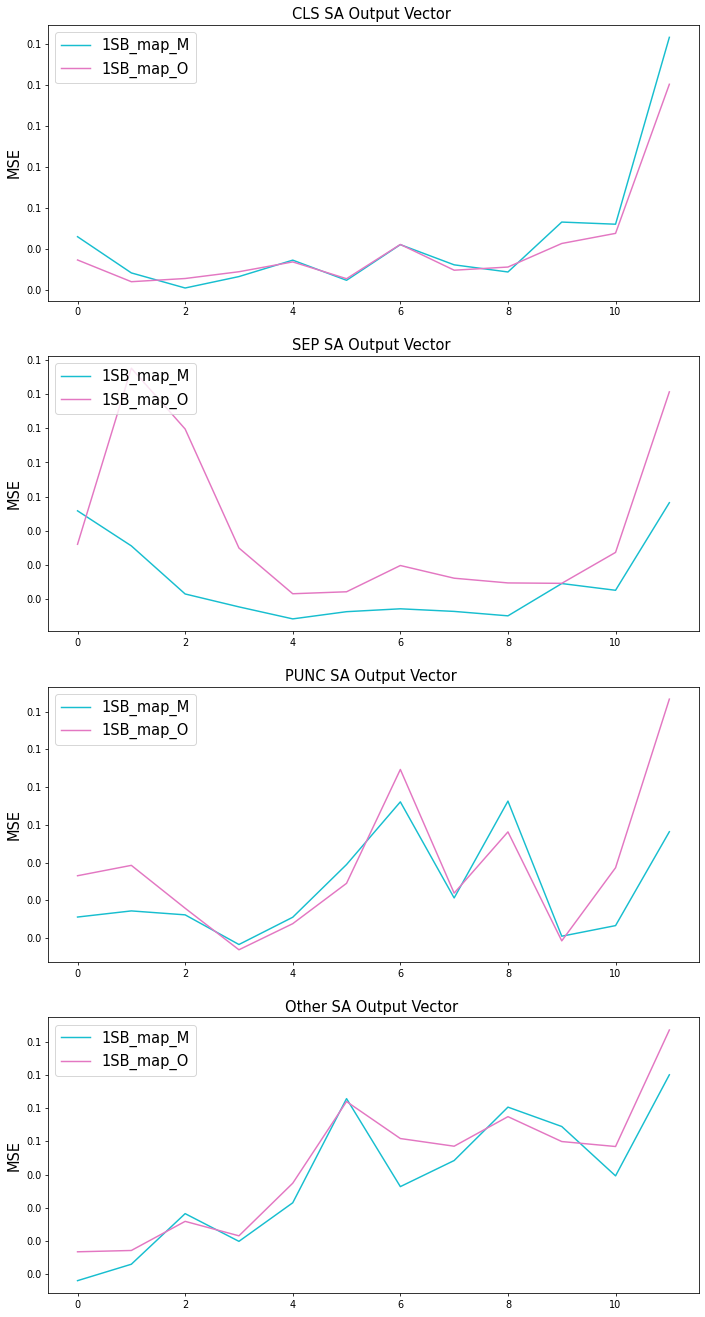

=> LayerNorm Output


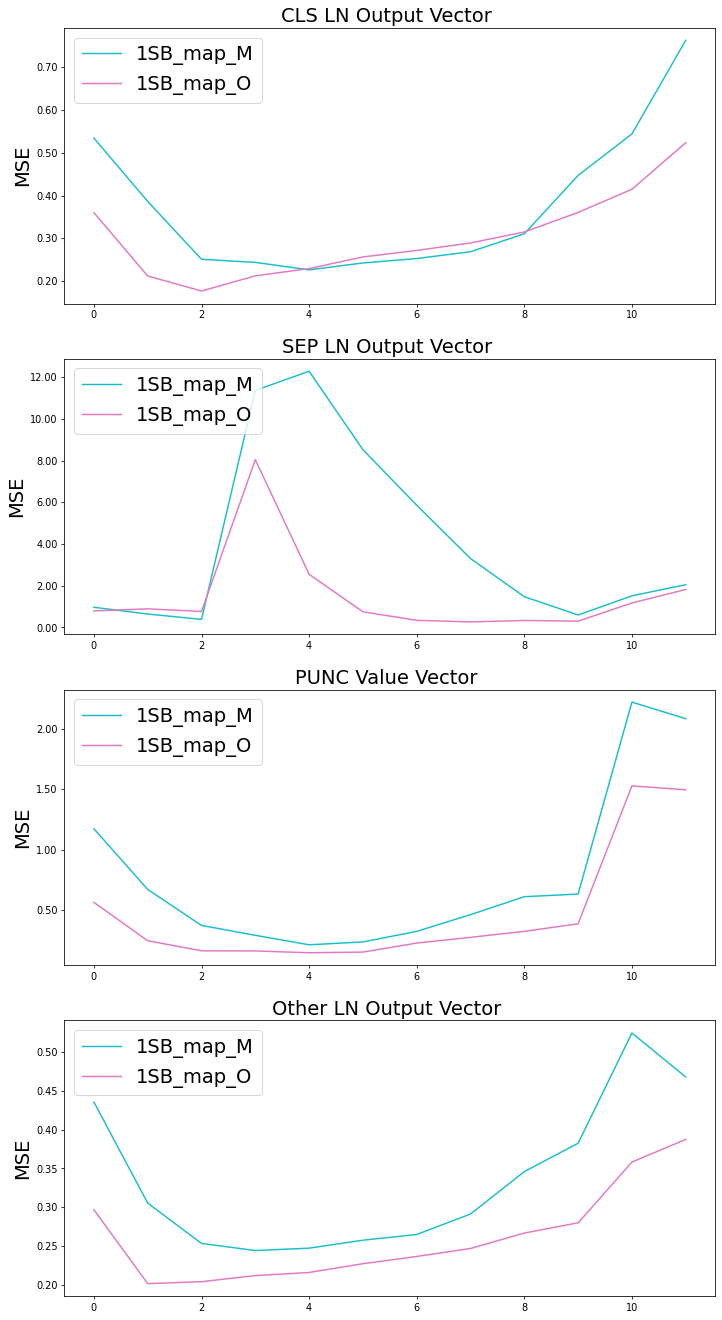

=> Attention Map KL Distance


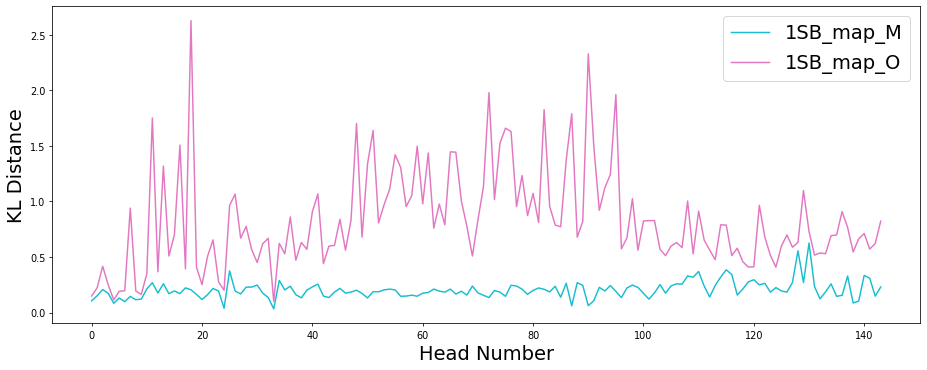

In [17]:
import matplotlib.ticker as mtick
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(12, 24), dpi=70)
font_size = 15
line_w =1.5

# x_axis_num = layer_num * head_num
x_axis_num = layer_num 
ax1_color = "tab:orange"
sarq_color = "tab:blue"
sarq_output_color_1 = "tab:cyan"
sarq_output_color_2 = "tab:pink"

# def plot(ax, dics):
#     for dic in dics
#         ax.plot(dic)

# ax1.plot(list(range(x_axis_num)),v_t_cls, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),v_s_cls, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),v_sc_cls, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),v_so_cls, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax1.legend(fontsize=font_size, loc=2)
ax1.set_ylabel("MSE", fontsize=font_size)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# ax1.set_title("CLS Context Vector ", fontsize=font_size, fontweight="light")
ax1.set_title("CLS SA Output Vector ", fontsize=font_size, fontweight="light")


# ax2.plot(list(range(x_axis_num)),v_t_sep, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),v_s_sep, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_sc_sep, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_so_sep, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax2.legend(fontsize=font_size, loc=2)
ax2.set_ylabel("MSE", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# ax2.set_title("SEP Context Vector ", fontsize=font_size, fontweight="light")
ax2.set_title("SEP SA Output Vector ", fontsize=font_size, fontweight="light")

# ax3.plot(list(range(x_axis_num)),v_t_punc, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),v_s_punc, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),v_sc_punc, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),v_so_punc, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax3.legend(fontsize=font_size, loc=2)
ax3.set_ylabel("MSE", fontsize=font_size)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# ax3.set_title("PUNC Context Vector ", fontsize=font_size, fontweight="light")
ax3.set_title("PUNC SA Output Vector ", fontsize=font_size, fontweight="light")

# ax4.plot(list(range(x_axis_num)),v_t_other, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),v_s_other, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),v_sc_other, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),v_so_other, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax4.legend(fontsize=font_size, loc=2)
ax4.set_ylabel("MSE", fontsize=font_size)
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# ax4.set_title("Other Context Vector ", fontsize=font_size, fontweight="light")
ax4.set_title("Other SA Output Vector ", fontsize=font_size, fontweight="light")
plt.show()

print("=====================================================================================================================")
print("=> LayerNorm Output") 
# print("=> Value Output") 
print("=====================================================================================================================")

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(12, 24), dpi=70)
line_w =1.5
font_size = 20
x_axis_num = layer_num

# ax1.plot(list(range(x_axis_num)),vw_t_cls, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_s_cls, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),vw_sc_cls, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),vw_so_cls, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax1.legend(fontsize=font_size, loc=2)
ax1.set_ylabel("MSE", fontsize=font_size)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax1.set_title("CLS LN Output Vector ", fontsize=font_size, fontweight="light")

# ax2.plot(list(range(x_axis_num)),vw_t_sep, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),vw_s_sep, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_sc_sep, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_so_sep, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax2.legend(fontsize=font_size, loc=2)
ax2.set_ylabel("MSE", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax2.set_title("SEP LN Output Vector ", fontsize=font_size, fontweight="light")

# ax3.plot(list(range(x_axis_num)),vw_t_punc, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),vw_s_punc, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),vw_sc_punc, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),vw_so_punc, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax3.legend(fontsize=font_size, loc=2)
ax3.set_ylabel("MSE", fontsize=font_size)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax3.set_title("PUNC Value Vector ", fontsize=font_size, fontweight="light")

# ax4.plot(list(range(x_axis_num)),vw_t_other, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),vw_s_other, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),vw_sc_other, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),vw_so_other, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax4.legend(fontsize=font_size, loc=2)
ax4.set_ylabel("MSE", fontsize=font_size)
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax4.set_title("Other LN Output Vector ", fontsize=font_size, fontweight="light")
plt.show()

print("=====================================================================================================================")
print("=> Attention Map KL Distance")
print("=====================================================================================================================")

x_axis_num = layer_num * head_num
font_size = 20
fig, ax = plt.subplots(1,1, figsize=(16, 6), dpi=70)
# ax.plot(list(range(x_axis_num)),kl_t, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax.plot(list(range(x_axis_num)),kl_s, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax.plot(list(range(x_axis_num)),kl_s_c, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax.plot(list(range(x_axis_num)),kl_s_o, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)
ax.set_ylabel("KL Distance", fontsize=font_size)
ax.set_xlabel("Head Number", fontsize=font_size)
ax.legend(fontsize=font_size, loc=1)



In [29]:
print(v_so_sep[169])
print(kl_s_o[160:180])

0.6669508218765259
[0.491291880607605, 0.6734030246734619, 0.15838806331157684, 1.0895506143569946, 0.5295109748840332, 0.6507244110107422, 0.8430217504501343, 0.4635698199272156, 0.5300043225288391, 0.7202023267745972, 0.657501220703125, 0.6439041495323181, 0.4996207058429718, 0.5659199357032776, 0.6876137256622314, 0.6206831336021423, 0.7935760021209717, 0.7056781649589539, 1.3128290176391602, 1.2883663177490234]


In [10]:
build_tc = 0
build_st = 1

ternary_name = "ternary_save"
sarq_name_1 = "step_2"
sarq_name_2 = "1SB_map_M"
sarq_name_3 = "1SB_map_O"

eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=128)

if build_tc:
    # Teacher Model Build
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()
    model = teacher_model
    

for st_model_name in [sarq_name_2, sarq_name_3]:
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   

    # Student Model Build
    print(f"{st_model_name} - Student Model Build")
    student_config = BertConfig.from_pretrained(student_model_dir)
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    model = student_model
    print(f"{st_model_name} - Student Model Inferece")
    student_model.eval()
    student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=None)
    print(f"Student Result : {student_result}")

eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)


# eval_st = 1
# eval_tc = 0

# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=32)

# if eval_st:
#     print("Student Model Inferece")
#     student_model.eval()
#     student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=teacher_model)
#     print(f"Student Result : {student_result}")

# if eval_tc:
#     print("Teacher Model Inferece")
#     teacher_result = do_eval(teacher_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels)
#     print(f"Teacher Result : {teacher_result}")
    
# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)

1SB_map_M - Student Model Build
05/09 10:56:35 AM loading configuration file output/BERT_large/rte/exploration/1SB_map_M/config.json
05/09 10:56:40 AM Loading model output/BERT_large/rte/exploration/1SB_map_M/pytorch_model.bin
05/09 10:56:41 AM loading model...
05/09 10:56:41 AM done!
1SB_map_M - Student Model Inferece


Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

Student Result : {'acc': 0.6353790613718412, 'eval_loss': 0.617641826470693}
1SB_map_O - Student Model Build
05/09 10:56:45 AM loading configuration file output/BERT_large/rte/exploration/1SB_map_O/config.json


05/09 10:56:50 AM Loading model output/BERT_large/rte/exploration/1SB_map_O/pytorch_model.bin
05/09 10:56:51 AM loading model...
05/09 10:56:52 AM done!
1SB_map_O - Student Model Inferece


Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

Student Result : {'acc': 0.6823104693140795, 'eval_loss': 0.5635660688082377}
